In [2]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [3]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [4]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(168528, 109)


,58394,155759,74129,72508
action_type,TOOL_HOVER,PLAYER_GAZE,BAG_CLOSED,PATIENT_DEMOTED
elapsed_time,452680,95947,260982,273258
event_time,2023-06-08 10:38:00,2023-09-11 14:18:47,2023-05-09 11:16:00,2023-05-10 09:21:00
session_uuid,2be0000b-9e0b-414f-a540-c495ffc28404,a3d6d913-7755-4e8d-a174-d5e491c4eac7,7dacebd5-f16e-4faa-8a00-f738b7d04e3b,7b239b94-a052-4a1f-929c-123a94426327
file_name,2be0000b-9e0b-414f-a540-c495ffc28404,a3d6d913-7755-4e8d-a174-d5e491c4eac7,7dacebd5-f16e-4faa-8a00-f738b7d04e3b,7b239b94-a052-4a1f-929c-123a94426327
logger_version,1.0,1.3,1.0,1.0
time_group,1,1,1,1
patient_demoted_health_level,NaN,NaN,NaN,100
patient_demoted_health_time_remaining,NaN,NaN,NaN,Infinity
patient_demoted_id,NaN,NaN,NaN,Gloria_6 Root



Preliminary Research Questions to consider for OSU Subway Bombing Data Set
1. Basic Questions

    A. Time To Hemorrhage Control for all responders

    B. Triage Efficiency (how long it take to triage the scene)

    C. Triage Accuracy (how many patients did they get right and do they do it in the right order; ie, Still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last)

    D. Subgroup analyses for each of the 3 items above: Medical Students, Residents, Physicians/Faculty/Fellows, First Responders
3. Efficiency and accuracy in triage of mass casualty

    A. distance travelled and efficiency vs accuracy (ie in looking at the maps, does a small footprint correlate to efficient performance). Do novice or lower level learners go back to the same patients multiple times?

    B. Future: correlation between gaze and intent.  If learner sees bleeding, do they treat it.
4. Determination of triage decisiveness, hover or bag open as an indicator (ie does a novice learner (medical student) open the bag or hover more than a more experienced learner (physician).
5. Are all mass casualty tasks similar in difficulty (wound packing, needle decompression, tourniquet application, triage tag determination) based on time spent.
6. Additional Metrics

    A. Performance
        
        1. Number of patients engaged (this could be including the ones that wave, walk, put hands up)
        2. Number of patients treated
        3. Time to first treatment
        4. Patient accuracy rate (how many patients correct / number of patients treated)
        5. Number of pulses taken by number of patients treated
        6. Treatment placement error (how far is treatment applied to location of wound. Zero would correspond to placing the treatment exactly on the wound)
    
    B. Scene Efficiency
    
        1. How many patients are treated between walk / wave commands
        2. Total number of teleports
        3. Total user actions taken
        4. Average time between user actions
        5. Interactions per patient

    C. Communication / Interaction
   
        1. How many times are walk / wave command issued
        2. What is the average time between walk / wave commands
        3. Number of voice captures per session (would be interesting to see if this correlates with anything)
        4. Voice capture content (themes of what they are saying)
8. Conditions to Analyze by

    A. Analyze results by which triage method deployed (SALT, START) if that can be distinguished
9. Questions

    A. Is low time to first treatment associated with higher performance?

    B. Are those that talk more, less efficient, lower performance?

    C. Are those that have lower average time between actions, higher in performance?

In [5]:

frvrs_logs_df.session_uuid.unique().shape

(146,)

In [7]:

columns_list = [cn for cn in frvrs_logs_df.columns if 'treat' in cn]
logger_version = 1.3
used_list = []
for cn in columns_list:
    mask_series = ~frvrs_logs_df[cn].isnull() & (frvrs_logs_df.logger_version == logger_version)
    record_count = frvrs_logs_df[mask_series].shape[0]
    if record_count:
        # print(cn)
        # display(frvrs_logs_df[mask_series].sample(min(4, record_count)).dropna(axis='columns', how='all').T)
        used_list.append(cn)
used_list = list(set(columns_list) - set(used_list))
if used_list:
    print(f"Logger version {logger_version} doesn't seem to use the treatment Boolean columns ({nu.conjunctify_nouns(used_list)}).")

In [15]:

# Patient accuracy rate (how many patients correct / number of patients treated)
rows_list = []
for (session_uuid, time_group), df1 in nu.get_session_groupby(extra_column='time_group'):
    logger_version = df1.logger_version.unique().item()
    row_dict = {}
    row_dict['logger_version'] = logger_version
    row_dict['session_uuid'] = session_uuid
    row_dict['time_group'] = time_group
    
    total_mask = (df1.injury_treated_injury_treated == True)
    df2 = df1[total_mask]
    total_treated = df2.shape[0]
    if total_treated:
        correct_mask = (df2.injury_treated_injury_treated_with_wrong_treatment == False)
        correctly_treated = df2[correct_mask].shape[0]
        row_dict['injury_treated_total_treated'] = total_treated
        row_dict['injury_treated_correctly_treated'] = correctly_treated
        row_dict['injury_treated_patient_accuracy_rate'] = correctly_treated / total_treated
    
    total_mask = (df1.injury_record_injury_treated == True)
    df2 = df1[total_mask]
    total_treated = df2.shape[0]
    if total_treated:
        correct_mask = (df2.injury_record_injury_treated_with_wrong_treatment == False)
        correctly_treated = df2[correct_mask].shape[0]
        row_dict['injury_record_total_treated'] = total_treated
        row_dict['injury_record_correctly_treated'] = correctly_treated
        row_dict['injury_record_patient_accuracy_rate'] = correctly_treated / total_treated
    
    rows_list.append(row_dict)
patient_accuracy_rate_df = DataFrame(rows_list)

In [19]:

# Show a sort of treated injury accuracy
mask_series = patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()
display(patient_accuracy_rate_df[~mask_series].logger_version.unique())
patient_accuracy_rate_df[~mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_total_treated'], ascending=[True, True]
)

array([1. , 1.3])

,logger_version,session_uuid,time_group,injury_treated_total_treated,injury_treated_correctly_treated,injury_treated_patient_accuracy_rate
109,1.0,46294fe1-e286-4772-8f71-3335a69a8dd2,1,3.0,1.0,0.333333
12,1.0,06574b6f-ab02-432c-9a65-7b031218a270,9,4.0,2.0,0.500000
170,1.0,724fdf45-3165-43b8-b9ca-dc07102d2886,8,4.0,2.0,0.500000
367,1.0,db948ce1-783d-4dff-a1f8-2be49570f327,1,4.0,2.0,0.500000
398,1.0,e9632b3b-77f2-4f62-a778-5d6a4242aa3b,1,4.0,2.0,0.500000
...,...,...,...,...,...,...
387,1.0,e3c2b4c6-d8b7-4b64-8cd0-7ca0e622f9b5,2,9.0,9.0,1.000000
395,1.0,e8cb6ae0-6d68-410f-88fc-4adf30d8bfac,2,9.0,9.0,1.000000
412,1.0,efed5e1c-4427-47df-8e3f-9e4714880169,2,9.0,9.0,1.000000
415,1.0,f0a4acff-b70a-4577-a27e-df492cb9638d,2,9.0,9.0,1.000000


In [7]:

mask_series = (patient_accuracy_rate_df.logger_version == 1.3)
patient_accuracy_rate_df[mask_series].shape

(40, 6)

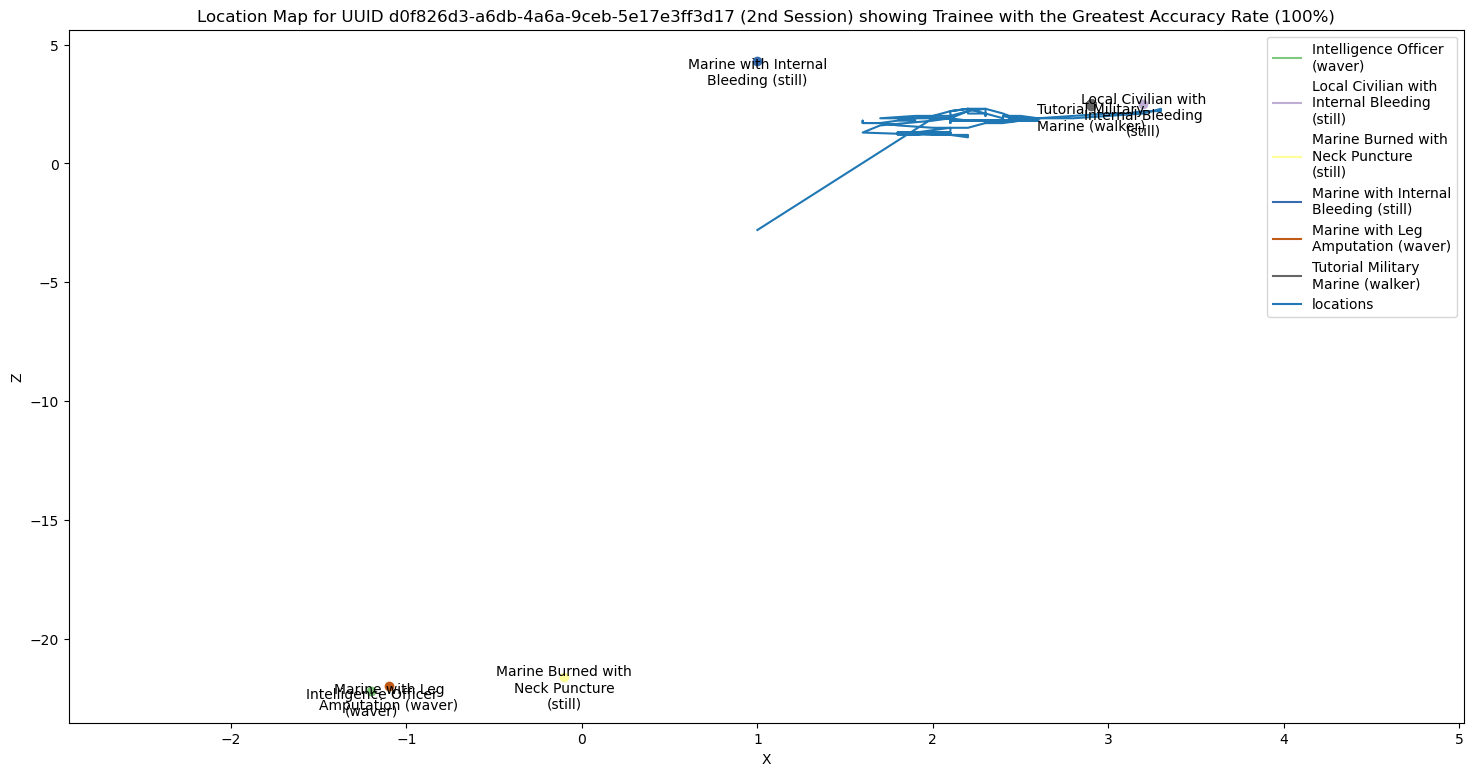

In [21]:

# Get time group with the greatest accuracy rate, v1.3
mask_series = (patient_accuracy_rate_df.logger_version == 1.3)
mask_series &= ~patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()
df = patient_accuracy_rate_df[mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_total_treated'], ascending=[True, True]
).tail(1)
if df.shape[0]:
    session_uuid = df.session_uuid.squeeze()
    time_group = df.time_group.squeeze()
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.time_group == time_group)
    
    title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(time_group+1)} Session)'
    title += ' showing Trainee with the Greatest Accuracy Rate ('
    patient_accuracy_rate = df.injury_treated_patient_accuracy_rate.min()
    title += humanize.intword(100 * patient_accuracy_rate, format='%d') + '%)'
    nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

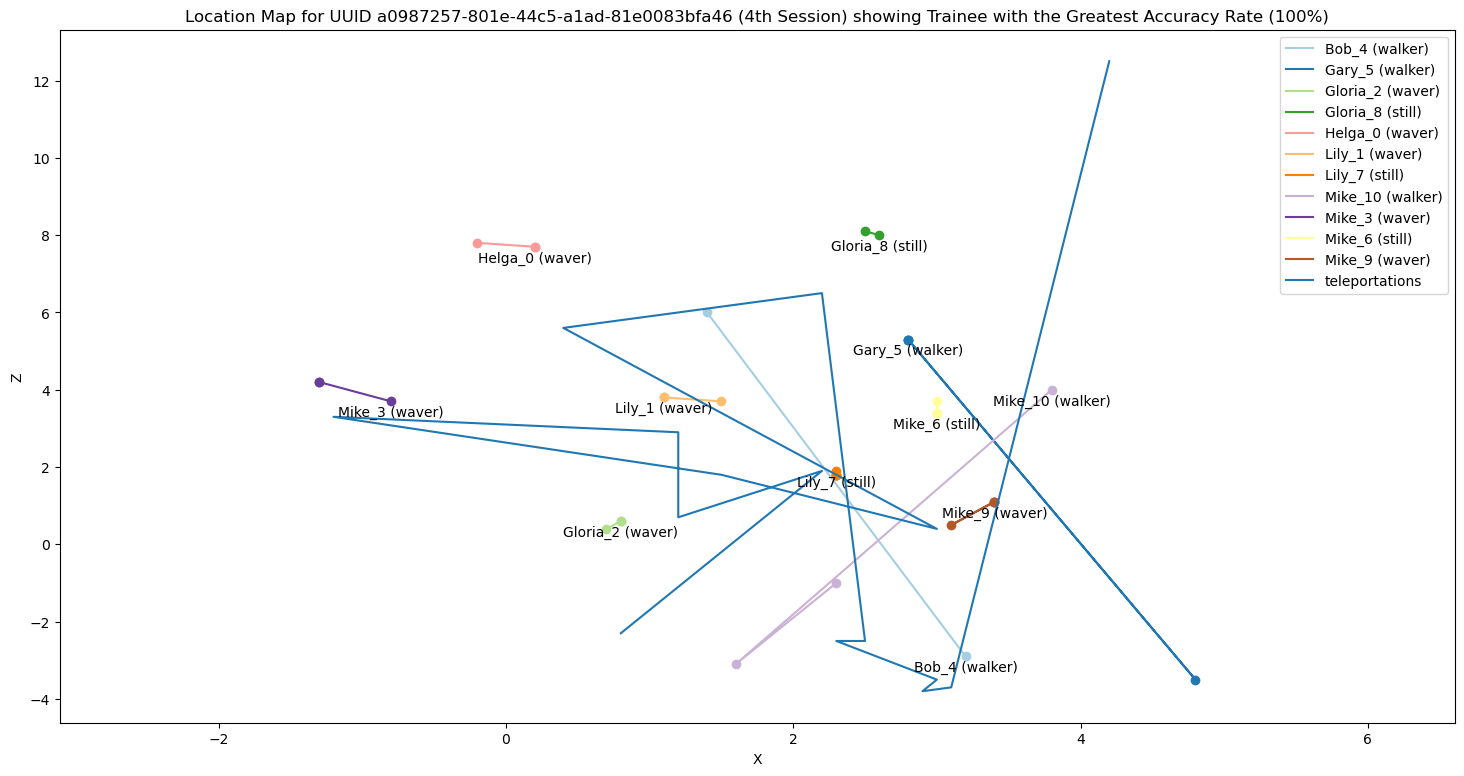

In [22]:

# Get time group with the greatest accuracy rate, v1.0
mask_series = (patient_accuracy_rate_df.logger_version == 1.0)
mask_series &= ~patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()
df = patient_accuracy_rate_df[mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_correctly_treated'], ascending=[True, True]
).tail(1)
if df.shape[0]:
    session_uuid = df.session_uuid.squeeze()
    time_group = df.time_group.squeeze()
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.time_group == time_group)
    
    title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(time_group+1)} Session)'
    title += ' showing Trainee with the Greatest Accuracy Rate ('
    patient_accuracy_rate = df.injury_treated_patient_accuracy_rate.min()
    title += humanize.intword(100 * patient_accuracy_rate, format='%d') + '%)'
    nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

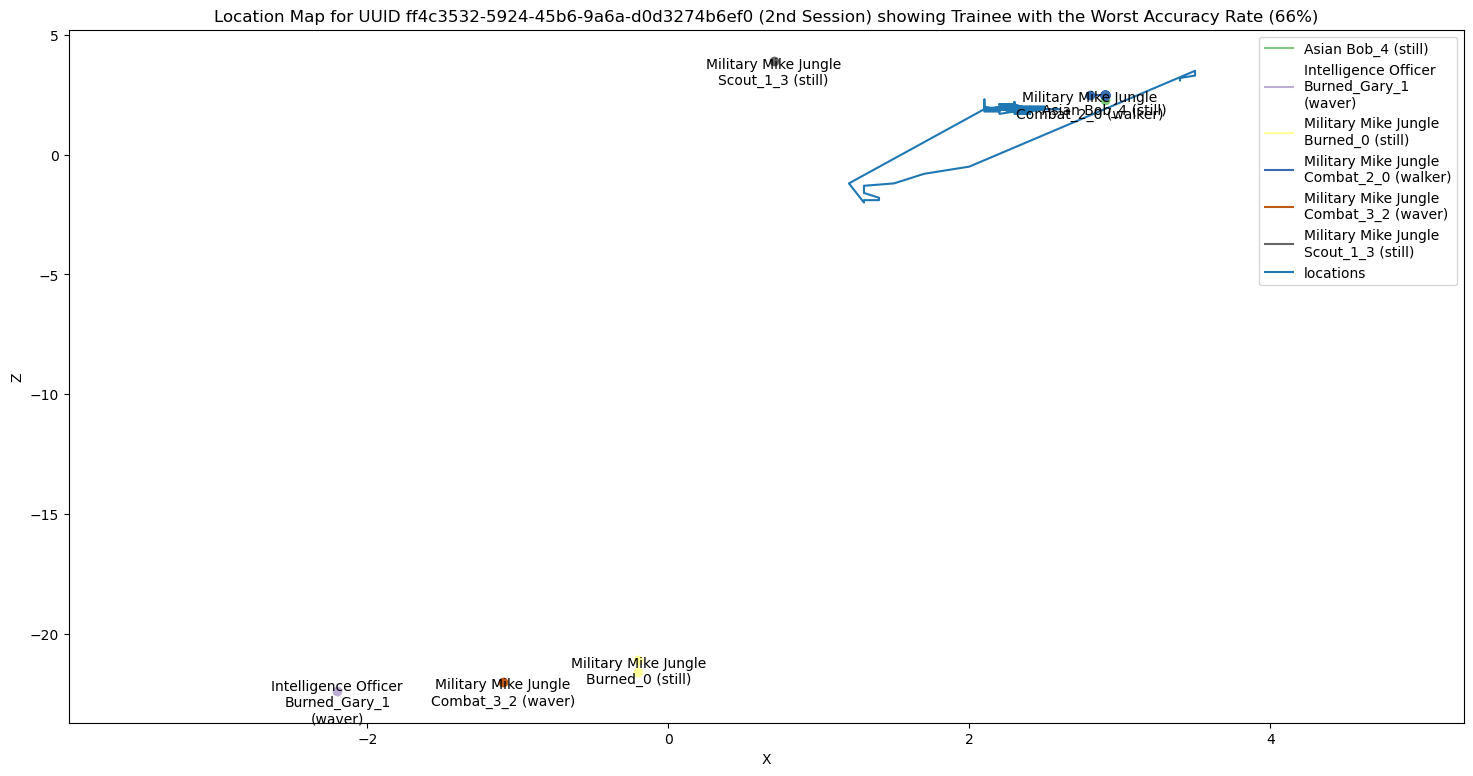

In [23]:

# Get time group with the worst accuracy rate, v1.3
mask_series = (patient_accuracy_rate_df.logger_version == 1.3)
mask_series &= ~patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()
df = patient_accuracy_rate_df[mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_correctly_treated'], ascending=[True, False]
).head(1)
if df.shape[0]:
    session_uuid = df.session_uuid.squeeze()
    time_group = df.time_group.squeeze()
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.time_group == time_group)
    
    title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(time_group+1)} Session)'
    title += ' showing Trainee with the Worst Accuracy Rate ('
    patient_accuracy_rate = df.injury_treated_patient_accuracy_rate.min()
    title += humanize.intword(100 * patient_accuracy_rate, format='%d') + '%)'
    nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

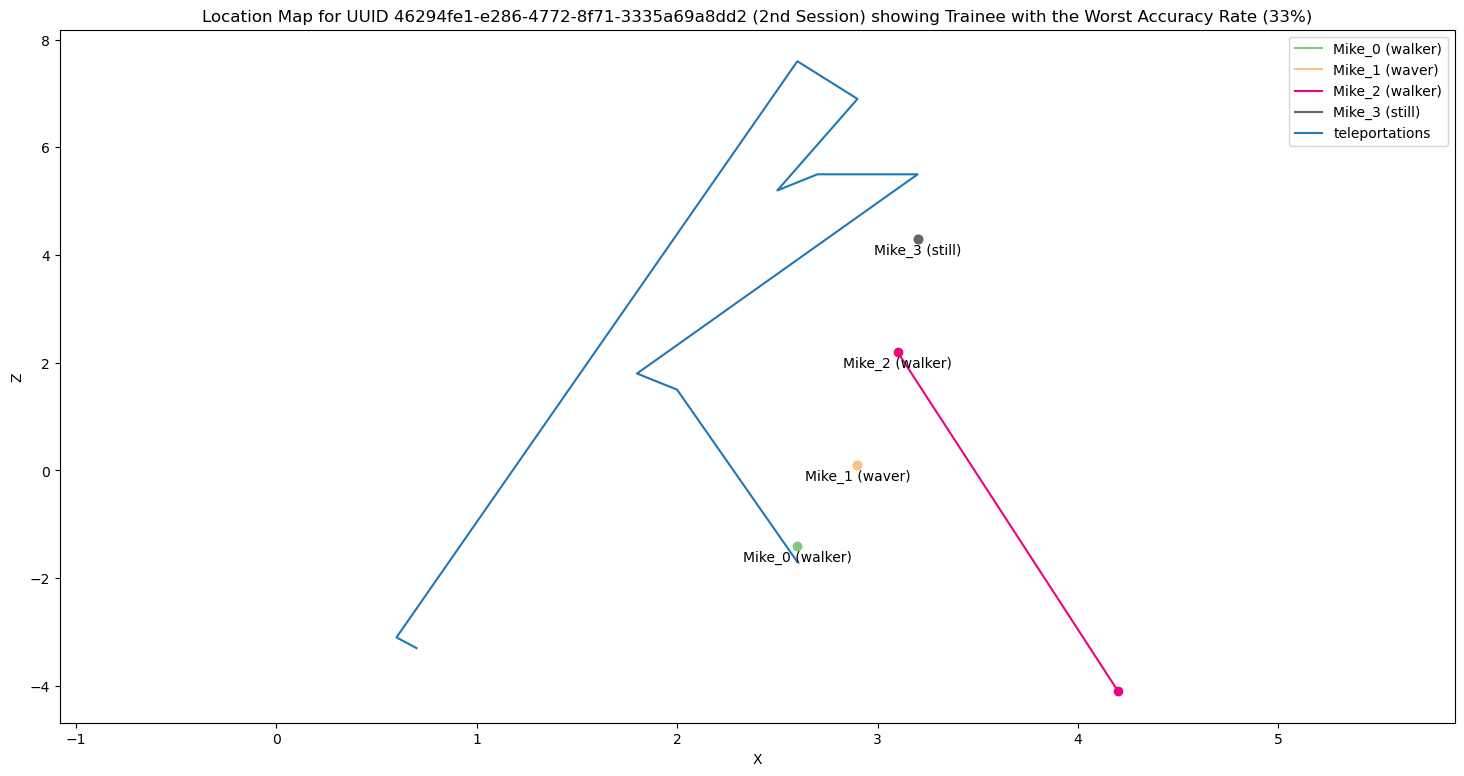

In [24]:

# Get time group with the worst accuracy rate, v1.0
mask_series = (patient_accuracy_rate_df.logger_version == 1.0)
mask_series &= ~patient_accuracy_rate_df.injury_treated_patient_accuracy_rate.isnull()
df = patient_accuracy_rate_df[mask_series].sort_values(
    ['injury_treated_patient_accuracy_rate', 'injury_treated_correctly_treated'], ascending=[True, False]
).head(1)
if df.shape[0]:
    session_uuid = df.session_uuid.squeeze()
    time_group = df.time_group.squeeze()
    base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.time_group == time_group)
    
    title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(time_group+1)} Session)'
    title += ' showing Trainee with the Worst Accuracy Rate ('
    patient_accuracy_rate = df.injury_treated_patient_accuracy_rate.min()
    title += humanize.intword(100 * patient_accuracy_rate, format='%d') + '%)'
    nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)